# Gogle Colab Set up

Running these cells allow colab to download the repo with the code need for this notebook.

In [ ]:
!git clone https://github.com/Juanki0396/TFG

In [ ]:
import os
os.chdir("TFG")

In [ ]:
!pip install -r requirements.txt
!mkdir save_models

# Training a classifier

In this notebook we will run 3 training steps comparing the classifying capacity of a Resnet with 3 different scenarios:

1. Images with random labels
2. Images with and without added noise
3. Original images without noise and noise images treated with a CycleGan

In [1]:
import random
from typing import List

import numpy as np
from torch.utils.data import DataLoader

from src.data.dataset import ImageDataset, CycleGanDataset , generate_noisy_dataset
from src.data.data_transforms import DynamicRangeScaling, RandomNoise, Resize
from src.data.image import Image
from src.models.clasifier_model import ImageClassifier
from src.models.cyclegan_model import CycleGan
from src.models.classifier_trainer import ClassifierTrainer
from src.models.cyclegan_trainer import CycleGanTrainer
from src.options.classifier_options import ClassifierOptions
from src.options.cyclegan_options import CycleGanOptions
from src.utils import load_xray_data, obtain_histogram

random.seed(12345)

## 0. Studying the dataset

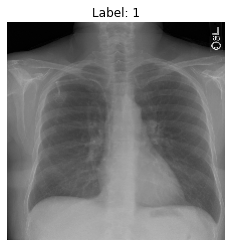

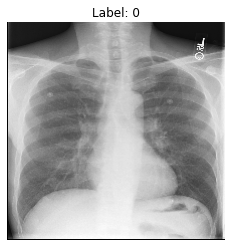

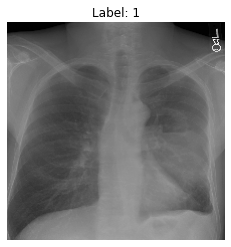

In [2]:
train_data, test_data = load_xray_data()

for image in random.sample(train_data, 3):
    image.plot(title=f"Label: {image.label}", figsize=(4,4))

Train data voxel histogram -> 90.0% of voxels are between [0.0, 6225.5]
Test data voxel histogram -> 99.0% of voxels are between [0.0, 3767.4]


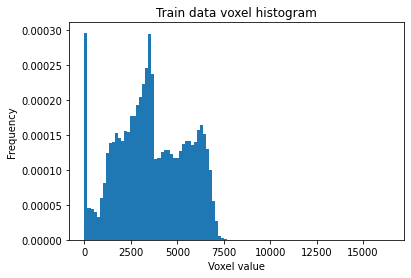

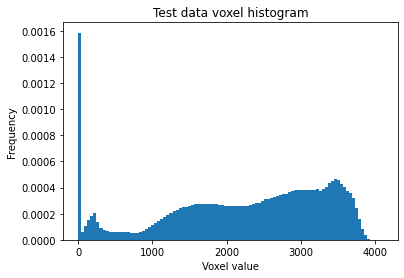

In [3]:
hist1 = obtain_histogram(train_data, sample_size=40, title="Train data voxel histogram", percentage=0.9)
hist2 = obtain_histogram(test_data, sample_size=40, title="Test data voxel histogram")

## 1. Images with random labels

-----------------------MODEL OPTIONS------------------------
Name                     ---->            random_labels
Device                   ---->                   cuda:0
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        1
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->       BinaryCrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       10
Image_size               ---->                 (64, 64)
Num_threads              ---->                        2
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                (0, 6000)

---------------------Training Epoch: 0----------------------
 Running training batch 37/37
Trainin

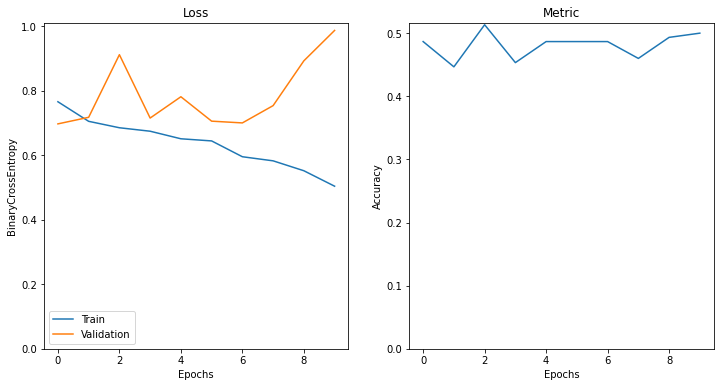

In [3]:
def randomise_labels(dataset: List[Image]) -> List[Image]:
    for image in dataset:
        image.label = random.randint(0,1)
    return dataset

# Load predefined options and modify some of them
options_parser = ClassifierOptions()
options_parser.read_parameters()
options_parser.gather_options()
options_parser.rewrite_option("name", "random_labels")
options_parser.rewrite_option("device", "cuda:0")
options_parser.print_options()

# Crate random labels
random_train_data = randomise_labels(train_data)
random_test_data = randomise_labels(test_data)

# Create torch datasets
transforms = [
    Resize(options_parser.options.image_size),
    DynamicRangeScaling(options_parser.options.model_dynamic_range, options_parser.options.crop_dynamic_range)
]
train_dataset = ImageDataset(random_train_data, transforms= transforms)
test_dataset = ImageDataset(random_test_data, transforms= transforms)

# Create models and trainer
model = ImageClassifier(options_parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, test_dataset)

# Train model
trainer.train_model()
loss_fig = trainer.plot_losses()


## 2. Images with and without added noise

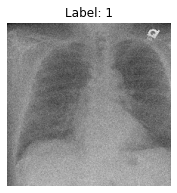

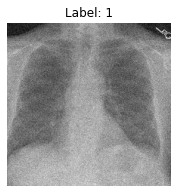

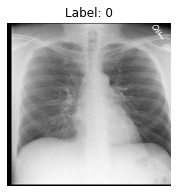

In [5]:
STD_NOISE = 400

train_data, test_data = load_xray_data()
train_noisy_data = generate_noisy_dataset(train_data, STD_NOISE)
test_noisy_data = generate_noisy_dataset(test_data, STD_NOISE)

for image in random.sample(train_data, 3):
    image.plot(title=f"Label: {image.label}", figsize=(3,3))

-----------------------MODEL OPTIONS------------------------
Name                     ---->              Noisy_xrays
Device                   ---->                   cuda:0
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        1
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->       BinaryCrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       10
Image_size               ---->                 (64, 64)
Num_threads              ---->                        2
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                (0, 6000)

---------------------Training Epoch: 0----------------------
 Running training batch 37/37
Trainin

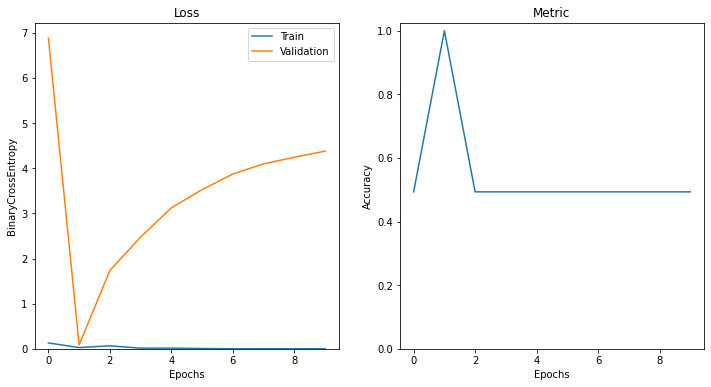

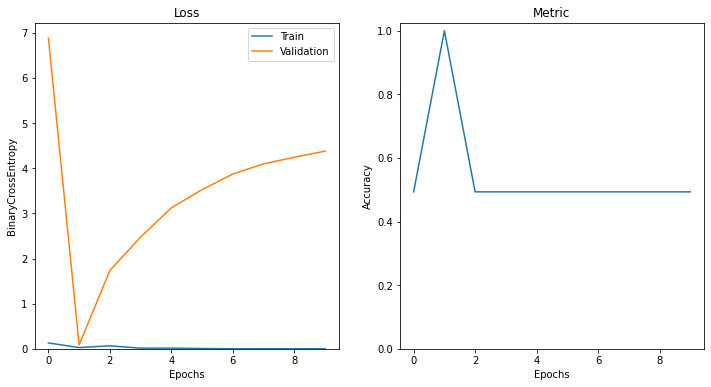

In [6]:
# Load predefined options and modify some of them
options_parser = ClassifierOptions()
options_parser.read_parameters()
options_parser.gather_options()
options_parser.rewrite_option("name", "Noisy_xrays")
options_parser.rewrite_option("device", "cuda:0")
options_parser.print_options()

# Create torch datasets
transforms = [
    Resize(options_parser.options.image_size),
    DynamicRangeScaling(options_parser.options.model_dynamic_range, options_parser.options.crop_dynamic_range)
]
train_noisy_dataset = ImageDataset(train_noisy_data, transforms=transforms)
test_noisy_dataset = ImageDataset(test_noisy_data, transforms=transforms)

# Create models and trainer
model = ImageClassifier(options_parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_noisy_dataset, test_noisy_dataset)

# Train model
trainer.train_model()
fig = trainer.plot_losses()

## 3. Real and CycleGan Images

In [ ]:
#TODO
cyclegan_train_data = generate_cycle_gan_dataset(train_data)
cyclegan_train_dataset = CycleGanDataset(cyclegan_train_data, image_output_size=IMAGE_SIZE)
cyclegan_test_data = generate_cycle_gan_dataset(test_data)
cyclegan_test_dataset = CycleGanDataset(cyclegan_test_data, image_output_size=IMAGE_SIZE)

epochs = 100
batch_size = 1
lr = 1e-3

model = CycleGan(device="cuda:0", lr=lr)
train_dataloader = DataLoader(cyclegan_train_dataset, batch_size=batch_size, shuffle=True)

train_manager = CycleGanTrainer(model, save_dir="./save_models")
train_manager.set_dataloaders(train_dataloader)
train_manager = train_cyclegan(train_manager, epochs=epochs)
fig = train_manager.plot_training_losses()